# Lab 4-7: Mixture Models+Model order selection

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import seaborn as sns
from scipy.stats import multivariate_normal
from __future__ import division
%matplotlib inline
#Setting plot parameters
sns.set_context('poster')
sns.set_color_codes()
plot_kwds = {'alpha' : 0.25, 's' : 80, 'linewidths':0}

We will have two toy datasets to try the different methods:

## GMM

A Gaussian mixture model is a probabilistic model that assumes all the data points are generated from a mixture of a finite number of Gaussian distributions with unknown parameters. After estimation of those parameters we get an estimation of the distribution of our data. For the clustering task, one can think of mixture models as generalizing k-means clustering to incorporate information about the covariance structure of the data as well as the centers of the latent Gaussians. 

### First part

Fill in the following class to implement a multivariate GMM:

In [2]:
class my_GMM():
    
    def __init__(self, k, initialization="kmeans"):
        '''
        Attributes:
        
        k_: integer
            number of components
        initialization_: {"kmeans", "random"}
            type of initialization
        mu_: np.array
            array containing means
        Sigma_: np.array
            array cointaining covariance matrix
        cond_prob_: (n, K) np.array
            conditional probabilities for all data points 
        labels_: (n, ) np.array
            labels for data points
        '''
        self.k_ = k
        self.initialization_ = initialization
        self.mu_ = None
        self.Sigma_ = None
        self.cond_prob_ = None
        self.labels_ = None
        self.pk_ = np.zeros((k,1))
        
    def initialisation_par(self,X,initialisation):
        "Find the initial value for the E-M algorithm."
        #Dimensions
        n = X.shape[0];
        p = X.shape[1]
        
        #Three dimension for Sigma: k pxp matrixes 
        self.Sigma_ = np.zeros((self.k_,p,p))
        
        if(initialisation == "kmeans"):
            # k-means computation
            n_it_km = 100
            kmeans_X = KMeans(n_clusters=self.k_, max_iter=n_it_km).fit(X)
            # compute the centroids
            self.mu_ = kmeans_X.cluster_centers_
            
            c_class = kmeans_X.labels_
            
            for i in range(self.k_):
                x_k = X[c_class == i]
                self.pk_[i] = len(x_k)/n
                self.Sigma_[i] = np.cov(x_k.T)

            #print("Mu:"+str(self.mu_))
            #print("Sigma:"+str(self.Sigma_)) 

        "Random initialisation"
            
    def fit(self, X):
        """ Find the parameters mu_ and Sigma_
        that better fit the data
        
        Parameters:
        -----------
        X: (n, p) np.array
            Data matrix
        
        Returns:
        -----
        self
        """
        "Initialisation"
        
        def compute_condition_prob_matrix(X, mu, Sigma):
            '''Compute the conditional probability matrix 
            shape: (n, K)
            '''
            n = X.shape[0]
            p = X.shape[1]
            
            f_i = np.zeros((self.k_,1))
            cond_prob = np.zeros((n,self.k_))
            
            for i in range(n):
                f_i = [multivariate_normal.pdf(X[i,:],mu[k],Sigma[k]) for k in range(self.k_)]
                num = np.multiply(self.pk_,f_i).T
                den = np.dot(f_i.T,self.pk_)
                cond_prob[i,:] = num/den
            return cond_prob
            
        def compute_expectation(X, mu, Sigma, cond_prob):
            '''Compute the expectation to check increment'''
            n = X.shape[0]
            p = X.shape[1]
            
            for k in range(self.k_):
                som = 0
                carre = 0
                self.pk_[k] = np.sum(cond_prob[:,k])/n
                som = sum([X[i,:]*cond_prob[i,k] for i in range(n)])
                mu[k] = som/(self.pk_[k]*n)
                carre = sum([np.reshape(np.kron(X[i,:] - mu[k],X[i,:] - mu[k]),(p,p))*cond_prob[i,k] for i in range(n)])
                Sigma[k] = carre/(self.pk_[k]*n)
                
        #Initialisation       
        self.initialisation_par(X, self.initialization_) 
        n = X.shape[0]
        p = X.shape[1]
        
        #Assign the attribute to another variable
        Sigma = self.Sigma_
        mu = self.mu_
        cond_prob = np.zeros((n,self.k_))
        n_it_EM = 200
        delta = 10^-3
        
        for i_it in range(n_it_EM):
            cond_prob = compute_condition_prob_matrix(X, mu, Sigma)
            tmp_mu = mu
            compute_expectation(X, mu, Sigma, cond_prob)
            
            if(np.linalg.norm(tmp_mu-mu) < delta):
                break
            
        self.mu_ = mu
        self.Sigma_ = Sigma
        self.cond_prob_ = cond_prob
                
        
    def predict(self, X):
        """ Predict labels for X
        
        Parameters:
        -----------
        X: (n, p) np.array
            New data matrix
        
        Returns:
        -----
        label assigment        
        """
        n = X.shape[0]
        self.labels_ = np.zeros((n,1))
        self.labels_ = [np.argmax(self.cond_prob_[i,:]) for i in range(n)]
        return self.labels_

# Generate your own mixture of Gaussian distributions to test the model, choose parameters so that GMM performs better than K-Means on it. Use `np.random.multivariate_normal`. 

Plot data with colors representing predicted labels and shapes representing real labels.

In [3]:
K = 4
M = 40
n = K*M

mu = np.array([[5,5],[-20,-20],[5,-5],[-20,20]])
print(mu.shape)
cov = np.array([ [[1,0],[0,5]],[[1,0],[0,1]],[[4,0],[0,1]],[[1,0],[0,12]] ])
X = np.zeros((K*M,2))

#generating m element for each cluster
i_d = 0
t_lab = []
for i_k in range(K):
    X[range(i_k*M,(i_k+1)*M,1),:] = np.random.multivariate_normal(mu[i_k],cov[i_k], M)
    for j in range(M):
        t_lab.append(i_k)     

(4, 2)


# An alternative version

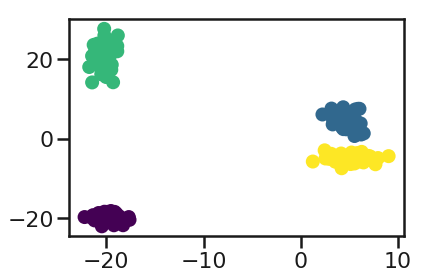

In [4]:
choice = "kmeans"
m1 = my_GMM(K,choice)
m1.fit(X)
m1.predict(X)

plt.scatter(X[:, 0], X[:, 1], c=m1.labels_.ravel(), cmap='viridis');

# Results for the true one

1543.915438843122


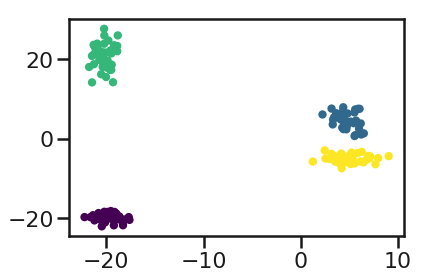

In [5]:
from sklearn.mixture import GaussianMixture

m2 = GaussianMixture(n_components=4).fit(X)
labels = m2.predict(X)
print(m2.aic(X))
plt.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis');

#### Bonus (not graded): Implement a mixture of asymmetric generalized Gaussians (AGGD)

## Second Part
 
- Implement the seen information criterions (AIC, BIC, etc.) to select the number of clusters:

In [7]:
# maximum number of classes
def info_criterions(X,offset,max_n_k,choice):
    lst_models = range(1,max_n_k)
    print(lst_models)

    n = X.shape[0]
    p = X.shape[1]

    sigmas = np.zeros((max_n_k,p,p))
    mus = np.zeros((max_n_k,p))

    AIC = np.zeros((max_n_k,1))
    BIC = np.zeros((max_n_k,1))

    for j in lst_models:
        
        m_complexity = j + offset
        
        m = my_GMM(m_complexity,choice)
        m.fit(X)
        m.predict(X)

        m_art = GaussianMixture(n_components=m_complexity).fit(X)

        sigmas = np.zeros((m_complexity,p,p))
        mus = np.zeros((m_complexity,p))

        mus = m.mu_
        sigmas = m.Sigma_
        ln_p_x_teta = 0

        for i in range(n):
            f_k = 0
            for k in range(m_complexity):
                f_k += m.pk_[k]*multivariate_normal.pdf(X[i,:],mus[k],sigmas[k])
            ln_p_x_teta += np.log(f_k)

        AIC[j-1] += ln_p_x_teta - j*(p**2 + 3*p)/2
        BIC[j-1] += ln_p_x_teta - n*j*(p**2 + 3*p)/4


    opt_n_class_AIC = np.argmax(AIC) + 1
    opt_n_class_BIC = np.argmax(BIC) + 1

    print(opt_n_class_AIC)        
    print(opt_n_class_BIC)        

    return opt_n_class_AIC, opt_n_class_BIC


# Implement the merge criterions 
    - Correlation coefficients
    - Measuring Error 
    - Comparing the parameters

# Correlation coefficients criterions (CC)

In [57]:
# IN: X (dataset), K = current number of classes, sigmas, mus
# OUT: update classes (the two merged classes will belong to a class such that its mean is... and its cov. is...)

def GMM_merge_classes(X, mus, sigmas, pk, posterior_prob, n_class_min):
    
    # Number of classes
    K = mus.shape[0]
    
    while( K > n_class_min):
        
        # Compute the indexes of the couple that will be merged
        i,j = my_max_i_j(K,posterior_prob)
                        
        # Get the new values
        tmp_mu,tmp_sigma,tmp_pk,tmp_posterior_prob =  merge_2_classes(mus[i], mus[j], sigmas[i], sigmas[j], pk[i], pk[j], posterior_prob[i], posterior_prob[j])          

        # Modify parameters
        mus = np.delete(mus, [i,j], axis = 0)
        tmp_mu = tmp_mu[np.newaxis,:]
        mus = np.append(mus, tmp_mu, axis = 0)

        sigmas = np.delete(sigmas, [i,j], axis = 0)
        tmp_sigma = tmp_sigma[np.newaxis,:]
        sigmas = np.append(sigmas, tmp_sigma, axis = 0)

        pk = np.delete(pk, [i,j])
        tmp_pk = np.array([tmp_pk])
        pk = np.append(pk, tmp_pk,axis = 0)

        posterior_prob = np.delete(posterior_prob, [i,j], axis = 0)
        tmp_posterior_prob = tmp_posterior_prob[np.newaxis,:]
        posterior_prob = np.append(posterior_prob, tmp_posterior_prob, axis = 0)  
        
        K = K -1
        
    return [mus, sigmas, pk, posterior_prob]

#Function which GMM merge classes exploits
def my_max_i_j(K,posterior_prob):
    max_J = 0
    for ii in range(K):
        for jj in range(K):
            if(ii < jj):
                candidate = compute_J(posterior_prob,ii,jj)
                if(candidate > max_J):
                    i = ii
                    j = jj
                    max_J = candidate
    return i,j                      
                        
def compute_J(posterior_prob,i,j):
    # Eq. 26 paper Zangh et al.
    return (posterior_prob[:,i].T.dot(posterior_prob[:,j]))/(np.linalg.norm(posterior_prob[:,i])*np.linalg.norm(posterior_prob[:,j]))

def merge_2_classes(mu_i, mu_j, sigma_i, sigma_j, pk_i, pk_j, posterior_prob_i, posterior_prob_j):
    # Eq. 12
    tmp_pk = pk_i + pk_j
    # Eq. 14
    tmp_mu = (pk_i*mu_i + pk_j*mu_j)/tmp_pk
    # Eq. 16
    tmp_sigma = pk_i*(sigma_i + mu_i.dot(mu_i.T)) + pk_j*(sigma_j + mu_j.dot(mu_j.T))
    tmp_sigma = tmp_sigma/(tmp_pk)
    tmp_sigma = tmp_sigma - tmp_mu.dot(tmp_mu.T)
    # Eq. 13
    tmp_posterior_prob = (pk_i*posterior_prob_i + pk_j*posterior_prob_j)/tmp_pk
    
    return tmp_mu,tmp_sigma,tmp_pk,tmp_posterior_prob

# Measuring Error Criterions (ME)

In [58]:
def ME_merge_classes(X, mus, sigmas, pk, posterior_prob, n_class_min, labels):
    
    # Number of classes
    K = mus.shape[0]
    
    #The tolerance between the two classes
    tol_perc = 10
    
    while( K > n_class_min):
        
        i = 0
        j = 0
        exit = False
        
        while( (i < K) and (exit == False) ):
            while( (j < K) and (exit == False) ):
                if(i < j):
                    
                    # Compute the the distances
                    d_i_d_j = mus[i] + mus[j]
                    dM = compute_means(X,i,j,labels)
                    dist = np.linalg.norm(dM - d_i_d_j)
                    norm_dij = np.linalg.norm(dM)
                    
                    # if dM simeq to dc1 + dc2
                    if( dist/norm_dij < tol_perc ):

                        print("Dist/norm :"+str(dist/norm_dij))

                        # Get the new values
                        tmp_mu,tmp_sigma,tmp_pk,tmp_posterior_prob =  merge_2_classes(mus[i], mus[j], sigmas[i], sigmas[j], pk[i], pk[j], posterior_prob[i], posterior_prob[j])          

                        # Modify parameters
                        mus = np.delete(mus, [i,j], axis = 0)
                        tmp_mu = tmp_mu[np.newaxis,:]
                        mus = np.append(mus, tmp_mu, axis = 0)

                        sigmas = np.delete(sigmas, [i,j], axis = 0)
                        tmp_sigma = tmp_sigma[np.newaxis,:]
                        sigmas = np.append(sigmas, tmp_sigma, axis = 0)

                        pk = np.delete(pk, [i,j])
                        tmp_pk = np.array([tmp_pk])
                        pk = np.append(pk, tmp_pk,axis = 0)

                        posterior_prob = np.delete(posterior_prob, [i,j], axis = 0)
                        tmp_posterior_prob = tmp_posterior_prob[np.newaxis,:]
                        posterior_prob = np.append(posterior_prob, tmp_posterior_prob, axis = 0)  

                        exit = True
                j += 1
            i+= 1
            
        K = K-1
    return [mus, sigmas, pk, posterior_prob]

def compute_means(X,i,j,labels):
    n = X.shape[0]
    som = 0
    n_el_class = 0
    for k in range(n):
        if( (labels[k] == i) or (labels[k] == j) ):
            som += X[k,:]
            n_el_class += 1
    return som/n_el_class   

# Comparing the parameters (CP)

In [59]:
def CP_merge_classes(X, mus, sigmas, p_k, cond_prob, labels, min_number_classes):
                
    N = mus.shape[0]    
        
    thresold_mus = 100
    thresold_sigma = 100
    
    counter = 0
    
    while(N>min_number_classes and counter < 100):
                
        i = np.random.randint(0, N)
        j = i
        while(j == i):
            j = np.random.randint(0, N)
        
        counter = counter + 1
        if(np.linalg.norm(mus[i]-mus[j]) < thresold_mus and np.linalg.norm(sigmas[i]-sigmas[j]) < thresold_sigma):
            
            n_i = 1/p_k[i]
            n_j = 1/p_k[j]
            
            tmp_mus = (n_i*mus[i]+n_j*mus[j])/(n_i+n_j)            
            mus = np.delete(mus, [i,j], axis = 0)
            tmp_mus = tmp_mus[np.newaxis,:]
            mus = np.append(mus, tmp_mus, axis = 0)
            
            tmp_pk = p_k[i]+p_k[j]
            p_k = np.delete(p_k, [i,j])
            p_k = np.append(p_k, tmp_pk)
            
            tmp_cond_prob = cond_prob[:, i] + cond_prob[:, j]
            cond_prob = np.delete(cond_prob, [i,j], axis = 1)
            tmp_cond_prob = tmp_cond_prob[:, np.newaxis]
            cond_prob = np.append(cond_prob, tmp_cond_prob, axis = 1)
            
            tmp = np.append(X[labels == i], X[labels == j], axis = 0)
            tmp_sigmas = np.cov(tmp.T)
            sigmas = np.delete(sigmas, [i,j], axis = 0)
            tmp_sigmas = tmp_sigmas[np.newaxis,:,:]
            sigmas = np.append(sigmas, tmp_sigmas, axis = 0)
            
            tmp_pos = mus.shape[0]+1
            
            labels[labels == i] = tmp_pos
            labels[labels == j] = tmp_pos
            labels[labels > i] -= 1
            labels[labels >= j] -= 1
            
            N = N - 1
                        
            counter = 0
    return [mus, sigmas, p_k, cond_prob]

# Merge Criterions: toy example

Trying our merging criterions with a toy example!

In [60]:
from sklearn.mixture import GaussianMixture

# Test merge 
m2 = GaussianMixture(n_components=4).fit(X)
labels = m2.predict(X)

mus = m2.means_ 
sigmas = m2.covariances_
pk = m2.weights_
posterior_prob = m2.predict_proba(X)

n_min_class = 2
choice = "CP"

if(choice == "CC"):
    mus,sigmas,pk,posterior_prob = GMM_merge_classes(X, mus, sigmas, pk, posterior_prob, n_min_class)
elif(choice == "ME"):
    mus,sigmas,pk,posterior_prob = ME_merge_classes(X, mus, sigmas, pk, posterior_prob, n_min_class, labels)
elif(choice == "CP"):
    mus,sigmas,pk,posterior_prob = CP_merge_classes(X, mus, sigmas, pk, posterior_prob, labels, n_min_class)
print(mus)

[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1]
[[  4.82194005  -0.16604817]
 [-19.9589128    0.39041912]]


# Cross-validation 

Our implementation of Cross Validation.

In [39]:
def log_vraisemblance(X, mus, sigmas, p_k, m_complexity):
    
    n = X.shape[0]
    
    ln_p_x_teta = 0
    
    for i in range(n):
            f_k = 0
            for k in range(m_complexity):
                f_k += p_k[k]*multivariate_normal.pdf(X[i,:],mus[k],sigmas[k])
            ln_p_x_teta += np.log(f_k)
    
    return ln_p_x_teta

def my_cross_validation(X,n_part,n_models):
    n = X.shape[0]
    l_window = n//n_part
    
    score = np.zeros((n_models, 1))
    
    for i in range(n_models):
        m_complexity = i + 1
        
        cum_error = 0

        print("Model: "+str(m_complexity))
        m = my_GMM(m_complexity)
        for i_val in range(n_part):
            print("Partition: "+str(i_val+1))
            train_dataset,validation_dataset = split_dataset(X,n_part,i_val)
            m.fit(train_dataset)
            cum_error += log_vraisemblance(validation_dataset, m.mu_, m.Sigma_, m.pk_, m_complexity)
            
        score[i] = cum_error/n_part
        
    return score

In [11]:
# IN: n_part the number of partition in which we split the data set ,i_val, the i_val-th partition is the validation set 
# OUT:train dataset and the validation dataset
def split_dataset(dataset,n_part,i_val):
    n = dataset.shape[0]
    l_window = n//n_part
    train_dataset = np.copy(dataset)
    train_dataset = np.delete(train_dataset, range(i_val*l_window,(i_val+1)*l_window,1), axis = 0)
    validation_dataset = dataset[range(i_val*l_window,(i_val+1)*l_window,1)]     
    return train_dataset,validation_dataset


# AIC - (loss function computation)

In [26]:
def AIC_LC(X,n_models):
    score = np.zeros((n_models,1))
    # updating best_score and n_comp_best_model
    for i in range(n_models):
        # Gaussian Mixture model
        GMM = GaussianMixture(i+1)
        GMM.fit(X)
        score[i] = GMM.aic(X)
        
    return score

# BIC - (loss function computation)

In [27]:
def BIC_LC(X,n_models):
    score = np.zeros((n_models,1))
    # updating best_score and n_comp_best_model
    for i in range(n_models):
        # Gaussian Mixture model
        GMM = GaussianMixture(i+1)
        GMM.fit(X)
        score[i] = GMM.bic(X)
    return score

# Performance in our data

Use the model selection criterions to choose the number of clusters for the two given datasets (data-MM-i.csv). Compare the results and the computational time. Try to visually validate your results.

# Import our data

In [19]:
import pandas as pd

n_1 = 800
n_2 = 1000

X1_data = pd.read_csv("data_MM_1.csv")
X1_train = X1_data.iloc[:n_1, :-1].values

X2_data = pd.read_csv("data_MM_2.csv")
X2_train = X2_data.iloc[:n_2, :-1].values

# First Data Set - Cross-validation, AIC, BIC

In [40]:
# number of models
n_models = 3
# number of partitions
n_part = 4

score_CV_1 = np.zeros((n_models, 1))
score_CV_1 = my_cross_validation(X1_train,n_part,n_models)
x_score = np.linspace(1, n_models, n_models, endpoint=True)

Model: 1
Partition: 1
Partition: 2
Partition: 3
Partition: 4
Model: 2
Partition: 1
Partition: 2
Partition: 3
Partition: 4
Model: 3
Partition: 1
Partition: 2
Partition: 3
Partition: 4


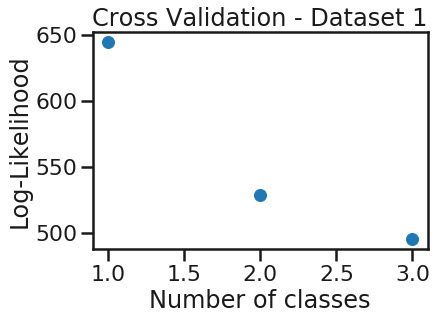

In [44]:
x_score = np.linspace(1, n_models, n_models, endpoint=True)

fig, ax = plt.subplots()
ax.plot(x_score, abs(score_CV_1), 'o')
plt.title('Cross Validation - Dataset 1')
plt.xlabel('Number of classes')
plt.ylabel('Log-Likelihood')
plt.subplots_adjust
plt.show()

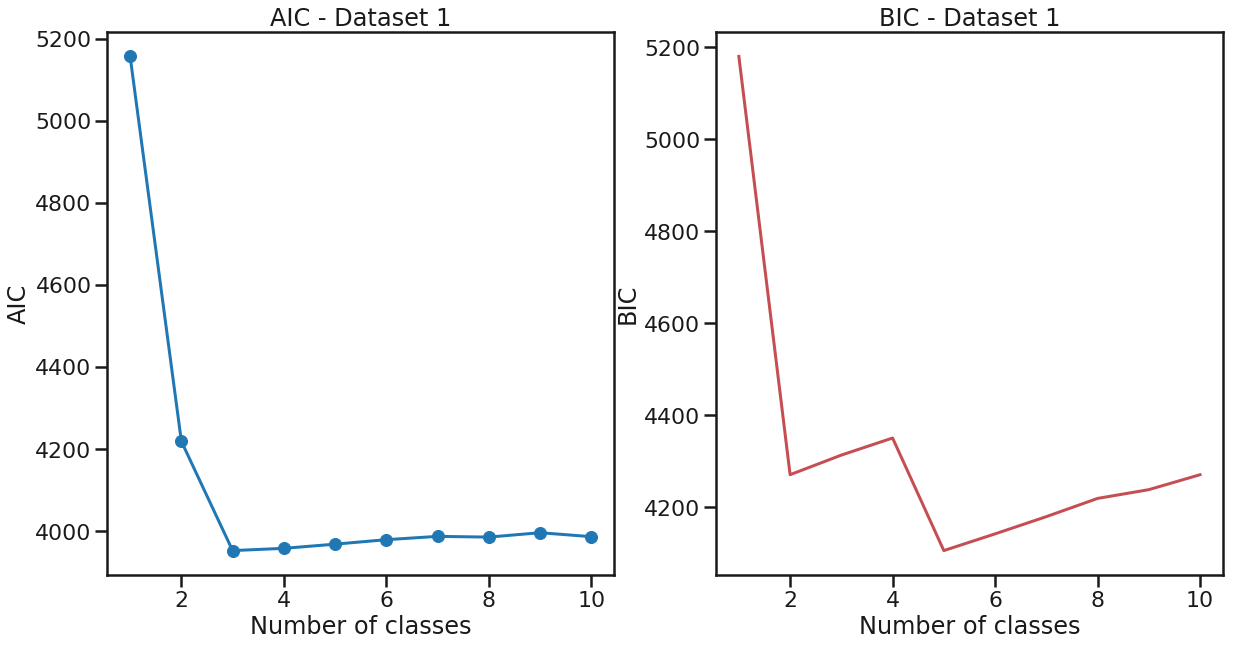

In [32]:
n_models = 10
x_score = np.linspace(1, n_models, n_models, endpoint=True)

score_aic_1 = AIC_LC(X1_train,n_models)
score_bic_1 = BIC_LC(X1_train,n_models)


plt.figure(figsize=(20,10))

plt.subplot(1,2,1)
plt.plot(x_score,score_aic_1, 'o-')
plt.title('AIC - Dataset 1')
plt.xlabel('Number of classes')
plt.ylabel('AIC')
plt.subplot(1,2,2)
plt.plot(x_score, score_bic_1, 'r-')
plt.title('BIC - Dataset 1')
plt.xlabel('Number of classes')
plt.ylabel('BIC')

plt.subplots_adjust

plt.show()

# Comments

In this case we pick:

- For the AIC criterion: Number of classes = 3
- For the BIC criterion: Number of classes = 5

# Second Data Set - Cross validation,AIC, BIC

In [45]:
# number of models
n_models = 3
# number of partitions
n_part = 4

score_CV_2 = np.zeros((n_models, 1))
score_CV_2 = my_cross_validation(X2_train,n_part,n_models)
x_score = np.linspace(1, n_models, n_models, endpoint=True)

Model: 1
Partition: 1
Partition: 2
Partition: 3
Partition: 4
Model: 2
Partition: 1
Partition: 2
Partition: 3
Partition: 4
Model: 3
Partition: 1
Partition: 2
Partition: 3
Partition: 4


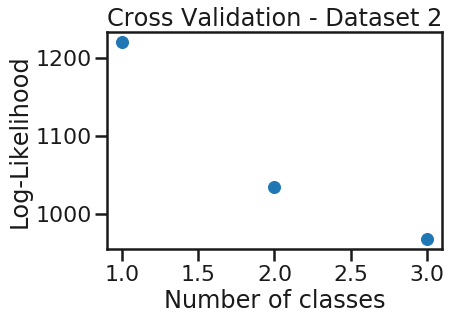

In [51]:
x_score = np.linspace(1, n_models, n_models, endpoint=True)

fig, ax = plt.subplots()
ax.plot(x_score, abs(score_CV_2), 'o')
plt.title('Cross Validation - Dataset 2')
plt.xlabel('Number of classes')
plt.ylabel('Log-Likelihood')

plt.subplots_adjust
plt.show()

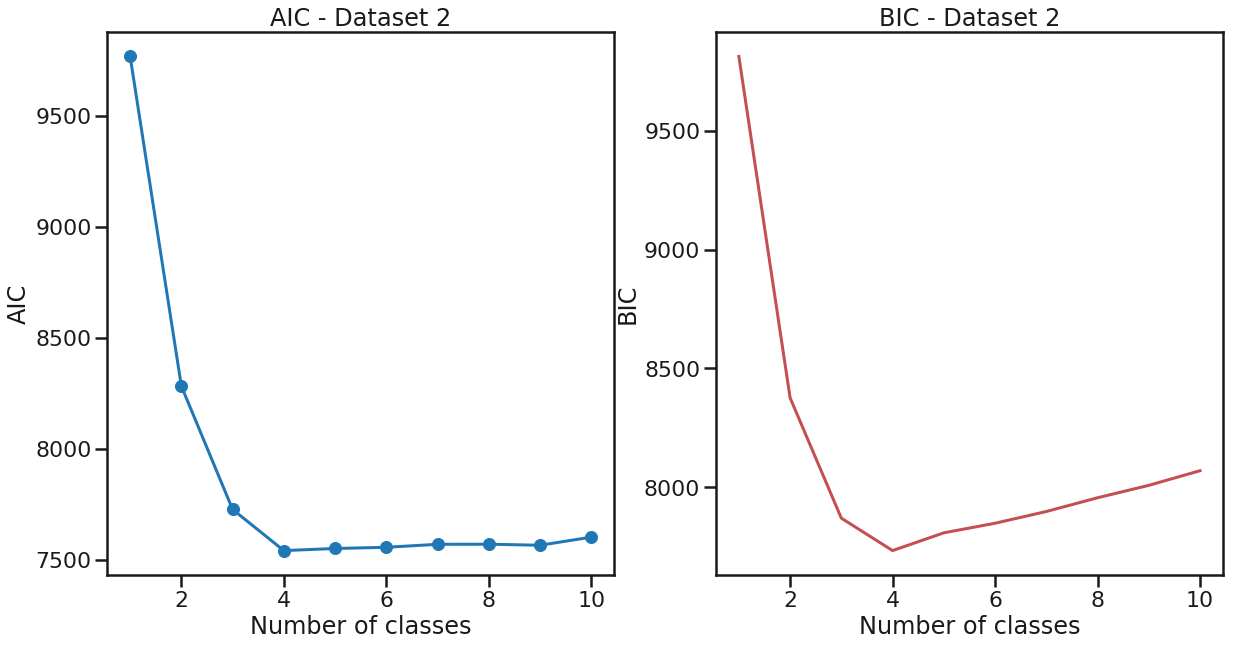

In [34]:
n_models = 10
x_score = np.linspace(1, n_models, n_models, endpoint=True)

score_aic_2 = AIC_LC(X2_train,n_models)
score_bic_2 = BIC_LC(X2_train,n_models)


plt.figure(figsize=(20,10))

plt.subplot(1,2,1)
plt.plot(x_score,score_aic_2, 'o-')
plt.title('AIC - Dataset 2')
plt.xlabel('Number of classes')
plt.ylabel('AIC')
plt.subplot(1,2,2)
plt.plot(x_score, score_bic_2, 'r-')
plt.title('BIC - Dataset 2')
plt.xlabel('Number of classes')
plt.ylabel('BIC')

plt.subplots_adjust

plt.show()

# Comments

In this case we pick:

- For the AIC criterion: Number of classes = 4
- For the BIC criterion: Number of classes = 4

# Application

You are going to work with the following data:

[1 2 3 4 5 6 7 8 9 0 9 5 5 6 5 0 9 8 9]
shape: (1797, 64)
[[ 0.  0.  5. ...  0.  0.  0.]
 [ 0.  0.  0. ... 10.  0.  0.]
 [ 0.  0.  0. ... 16.  9.  0.]
 ...
 [ 0.  0.  1. ...  6.  0.  0.]
 [ 0.  0.  2. ... 12.  0.  0.]
 [ 0.  0. 10. ... 12.  1.  0.]]


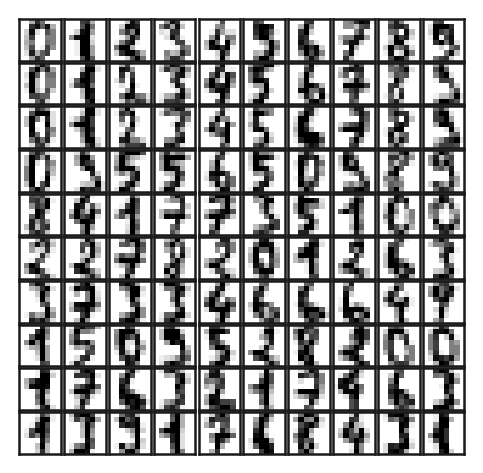

In [61]:
from sklearn.datasets import load_digits
digits = load_digits()
print(digits.target[21:40])
print("shape:", digits.data.shape)

def plot_digits(data):
    fig, ax = plt.subplots(10, 10, figsize=(8, 8),
                           subplot_kw=dict(xticks=[], yticks=[]))
    fig.subplots_adjust(hspace=0.05, wspace=0.05)
    for i, axi in enumerate(ax.flat):
        im = axi.imshow(data[i].reshape(8, 8), cmap='binary')
        im.set_clim(0, 16)
plot_digits(digits.data)
print(digits.data)

# Model your data with your GMM class using a model order selection method and produce new synthetic handwritten numbers. 

You should use PCA to reduce the dimension as GMM doesn't perform well in high-dimensional contexts. 

# OUR WORK


We generate our digits and we then plot them.

# Steps:

1) Computation of the PCA of the digits dataset 

2) Find the best model according to aic criterion

3) Merge classes according to differents criterions ( CC, CP ), 'till we have 20 classes.

We've firstly chosen 10 classes but we've then realised that some digits weren't represented by GMM classes. Therefore, we've added 10 additional classes to obtain at least one igit representation for each digit.

In [62]:
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from numpy.random import multivariate_normal

# doing PCA
pca = PCA(0.99, whiten=True)
new_data = pca.fit_transform(digits.data)

p_reduced = new_data.shape[1]

# initialing best_score
best_score = 100000000

# initialing n_comp_best_model
n_comp_best_model = 100

# initialing number_models that we try
number_models = 60

# updating best_score and n_comp_best_model
for i in range(number_models):
    
    # Gaussian Mixture model
    GMM = GaussianMixture(i+1)
    GMM.fit(new_data)
    
    # initializing tmp_score
    tmp_score = GMM.aic(new_data)
    
    # updating best_score and n_comp_best_model
    if(tmp_score < best_score):
        best_score = tmp_score
        n_comp_best_model = i

print(n_comp_best_model)

58


# Best model based on AIC

In [63]:
best_model = GaussianMixture(n_comp_best_model)
best_model.fit(new_data)

mus_best_model = best_model.means_ 
sigmas_best_model = best_model.covariances_
pk_best_model = best_model.weights_
posterior_prob_best_model = best_model.predict_proba(new_data)
labels_best_model = best_model.predict(new_data)

n_min_class = 15

mus_1,sigmas_1,pk_1,posterior_prob_1 = GMM_merge_classes(new_data, mus_best_model, sigmas_best_model, pk_best_model, posterior_prob_best_model, n_min_class)
mus_2,sigmas_2,pk_2,posterior_prob_2 = CP_merge_classes(new_data, mus_best_model, sigmas_best_model, pk_best_model, posterior_prob_best_model, labels_best_model, n_min_class)

[18 49 27 ... 53  2 31]
[17 48 26 ... 51  2 30]
[17 47 25 ... 50  2 29]
[17 45 25 ... 48  2 29]
[17 43 25 ... 46  2 28]
[17 41 24 ... 44  2 27]
[16 50 23 ... 42  2 26]
[15 48 22 ... 40  2 25]
[14 46 21 ... 38  2 24]
[13 44 20 ... 47  2 23]
[12 42 19 ... 45 46 22]
[12 40 19 ... 43 44 21]
[12 38 17 ... 41 42 19]
[11 36 16 ... 39 40 18]
[11 34 15 ... 37 38 16]
[10 32 14 ... 35 36 15]
[ 9 30 13 ... 33 34 40]
[ 9 29 13 ... 39 32 38]
[ 9 29 13 ... 37 32 36]
[ 9 28 12 ... 35 37 34]
[ 9 27 36 ... 34 35 33]
[ 9 26 34 ... 35 33 32]
[ 8 25 32 ... 33 31 30]
[ 6 23 30 ... 31 29 28]
[ 6 23 32 ... 29 28 27]
[ 5 21 30 ... 27 26 25]
[ 4 20 28 ... 25 24 23]
[ 4 29 26 ... 23 22 21]
[ 4 27 24 ... 21 20 19]
[ 4 25 22 ... 27 20 19]
[ 4 24 21 ... 25 19 18]
[ 4 22 20 ... 23 18 17]
[ 3 20 19 ... 21 17 16]
[ 3 18 17 ... 19 15 14]
[ 3 17 16 ... 18 14 13]
[ 2 15 14 ... 16 12 11]
[ 2 14 13 ... 15 11 10]
[ 2 12 11 ... 13 10  9]
[ 2 10  9 ... 11  8  7]
[ 2  9  8 ... 10  7  6]
[ 2  8  7 ...  9 16  6]
[ 2  6  5 ...  7

# Our digits 

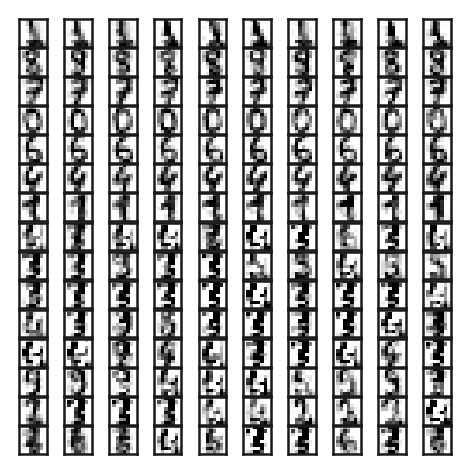

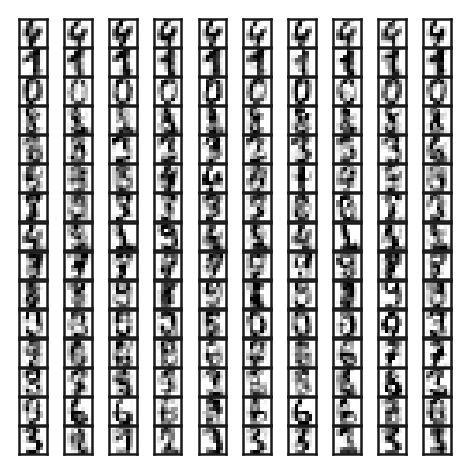

In [64]:
def plot_digits(data, dim, n_min_class, n_samples_class):
    fig, ax = plt.subplots(n_min_class, n_samples_class, figsize=(dim, dim),
                           subplot_kw=dict(xticks=[], yticks=[]))
    fig.subplots_adjust(hspace=0.05, wspace=0.05)
    for i, axi in enumerate(ax.flat):
        im = axi.imshow(data[i].reshape(dim, dim), cmap='binary')
        im.set_clim(0, 16)

# number of samples for each class
n_samples_class = 10
        
our_digits_1 = np.zeros((n_samples_class*n_min_class,p_reduced))

our_digits_2 = np.zeros((n_samples_class*n_min_class,p_reduced))

# Generating points
for i_k in range(n_min_class):
    our_digits_1[range(i_k*n_samples_class,(i_k+1)*n_samples_class,1),:] = np.random.multivariate_normal(mus_1[i_k],sigmas_1[i_k], n_samples_class)
    our_digits_2[range(i_k*n_samples_class,(i_k+1)*n_samples_class,1),:] = np.random.multivariate_normal(mus_2[i_k],sigmas_2[i_k], n_samples_class)


digits_new_1 = pca.inverse_transform(our_digits_1)
digits_new_2 = pca.inverse_transform(our_digits_2)

plot_digits(digits_new_1, 8, n_min_class, n_samples_class)
plot_digits(digits_new_2, 8, n_min_class, n_samples_class)

# Digits without merging. Here only 10 classes are used 

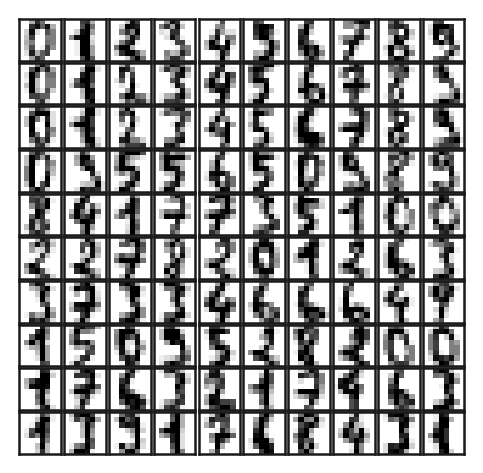

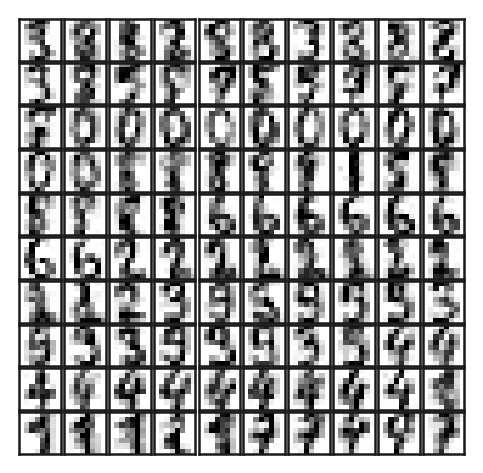

In [66]:
from sklearn.datasets import load_digits
digits = load_digits()

def plot_digits(data):
    fig, ax = plt.subplots(10, 10, figsize=(8, 8),
                           subplot_kw=dict(xticks=[], yticks=[]))
    fig.subplots_adjust(hspace=0.05, wspace=0.05)
    for i, axi in enumerate(ax.flat):
        im = axi.imshow(data[i].reshape(8, 8), cmap='binary')
        im.set_clim(0, 16)
plot_digits(digits.data)

### fitting model ####

from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture

pca = PCA(0.99, whiten=True)
digits = pca.fit_transform(digits.data)
digits.shape

gmm = GaussianMixture(10, covariance_type='full', random_state=0)
gmm.fit(digits)

### sampling ####

data_new = gmm.sample(100)
digits_new = pca.inverse_transform(data_new[0])
plot_digits(digits_new)
